Modality (01 = full-AV, 02 = video-only, 03 = audio-only).<br/>
Vocal channel (01 = speech, 02 = song).<br/>
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).<br/>
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.<br/>
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").<br/>
Repetition (01 = 1st repetition, 02 = 2nd repetition).<br/>
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).<br/>

In [1]:
emotion_map = {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : 
                 "fearful", "07" : "disgust", "08" : "surprised"}
emotion_map_int = {int(i) : j for i, j in emotion_map.items()}
emotion_map_rev = {j : int(i) for i, j in emotion_map.items()}

In [41]:
import librosa
from librosa import display

from IPython.display import Audio
from glob import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
from time import time


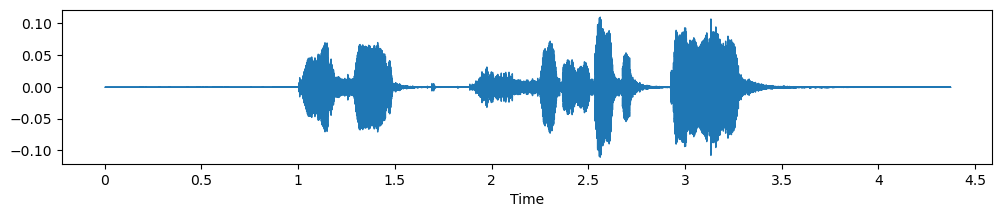

In [3]:
# Pick a random file and observe the data
random_audio = np.random.choice(glob('./Audio Speech Actors/*/*'))
audio, sr = librosa.load(random_audio, res_type='kaiser_fast')
plt.figure(figsize = (12,2))
librosa.display.waveshow(audio, sr = sr)
Audio(random_audio)

In [4]:
dataset = []

for file_name in tqdm(glob('./Audio Speech Actors/*/*')):
    Emotion = file_name.split('\\')[-1].strip('.wav').split('-')[2]
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfcc = np.mean(mfcc, axis = 1)
    dataset.append([mfcc, emotion_map.get(Emotion)])

for file_name in tqdm(glob('./Audio_Song_Actors_01-24/*/*')):
    Emotion = file_name.split('\\')[-1].strip('.wav').split('-')[2]
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfcc = np.mean(mfcc, axis = 1)
    dataset.append([mfcc, emotion_map.get(Emotion)])    

for file_name in tqdm(glob('./TESS Toronto Emotional Speech/*/*')):
    Emotion = file_name.split('\\')[-2].split('_')[-1].lower()
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfcc = np.mean(mfcc, axis = 1)
    dataset.append([mfcc, Emotion])

    
data = pd.DataFrame(dataset, columns = ['audio_features_mfcc', 'emotion'])

100%|██████████████████████████████████████████████████████████████████████████████| 2800/2800 [01:59<00:00, 23.51it/s]


In [5]:
data.head()

,audio_features_mfcc,emotion
0,"[-700.04803, 58.141853, -2.5586066, 15.606679,...",neutral
1,"[-695.1851, 58.72073, -4.8757935, 19.315145, 5...",neutral
2,"[-693.6901, 61.060158, -2.8490763, 16.58725, 2...",neutral
3,"[-687.24304, 58.96541, -0.27530542, 16.264652,...",neutral
4,"[-729.57996, 65.91619, -0.40742576, 18.537952,...",calm


In [6]:
df = pd.DataFrame(data.audio_features_mfcc.tolist()).fillna(0.0)
df['emotion'] = data['emotion'].replace({'fearful' : 'fear', 'surprised': 'surprise'})
del data
df.to_csv('./data.csv', index = False)

In [7]:
encoder = LabelEncoder()
df['emotion'] = encoder.fit_transform(df['emotion'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['emotion']), df['emotion'], 
                                                        test_size=0.33, random_state=42)

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

print(x_traincnn.shape, x_testcnn.shape)

model = Sequential()
model.add(Conv1D(64, 5, padding='same',
                 input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

print(model.summary())

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn_history = model.fit(x_traincnn, y_train,
                       batch_size=32, epochs=75,
                       validation_data=(x_testcnn, y_test))


(2973, 40, 1) (1465, 40, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 64)            384       
                                                                 
 activation (Activation)     (None, 40, 64)            0         
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 8)                 20488     
                                                                 
 activation_1 (Activation)   (None, 8)                 0         
                                                                 
Total params: 20,872
Trainab

93/93 [==============================] - 1s 7ms/step - loss: 0.3439 - accuracy: 0.8782 - val_loss: 0.5979 - val_accuracy: 0.8075
Epoch 51/75
93/93 [==============================] - 1s 7ms/step - loss: 0.3493 - accuracy: 0.8809 - val_loss: 0.5903 - val_accuracy: 0.8075
Epoch 52/75
93/93 [==============================] - 1s 7ms/step - loss: 0.3333 - accuracy: 0.8846 - val_loss: 0.5564 - val_accuracy: 0.8171
Epoch 53/75
93/93 [==============================] - 1s 7ms/step - loss: 0.3397 - accuracy: 0.8792 - val_loss: 0.6071 - val_accuracy: 0.8014
Epoch 54/75
93/93 [==============================] - 1s 9ms/step - loss: 0.3311 - accuracy: 0.8836 - val_loss: 0.6506 - val_accuracy: 0.8055
Epoch 55/75
93/93 [==============================] - 1s 8ms/step - loss: 0.3205 - accuracy: 0.8850 - val_loss: 0.6188 - val_accuracy: 0.8143
Epoch 56/75
93/93 [==============================] - 1s 9ms/step - loss: 0.3294 - accuracy: 0.8796 - val_loss: 0.5744 - val_accuracy: 0.8212
Epoch 57/75
93/93 [======

46/46 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       angry       0.91      0.78      0.84       199
        calm       0.64      0.79      0.71        75
     disgust       0.93      0.73      0.82       176
        fear       0.75      0.87      0.80       212
       happy       0.78      0.80      0.79       212
     neutral       0.91      0.89      0.90       165
         sad       0.79      0.78      0.78       212
    surprise       0.79      0.85      0.82       214

    accuracy                           0.81      1465
   macro avg       0.81      0.81      0.81      1465
weighted avg       0.82      0.81      0.81      1465



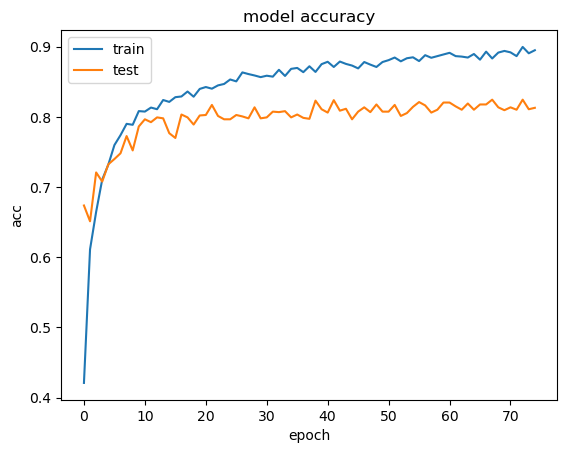

In [11]:
# Loss plotting
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.close()

# Accuracy plotting
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png')

predictions = encoder.inverse_transform(model.predict(x_testcnn).argmax(axis=1))
new_y_test = encoder.inverse_transform(y_test)
matrix = confusion_matrix(new_y_test, predictions)

print(classification_report(new_y_test, predictions))

model_name = 'Emotion_Voice_Detection_Model.h5'
model.save(model_name)

,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,155,1,0,7,15,4,3,14
calm,0,59,4,2,2,1,6,1
disgust,9,3,129,12,4,2,6,11
fear,1,1,2,185,8,0,10,5
happy,2,9,1,13,169,2,7,9
neutral,0,3,2,0,1,147,9,3
sad,2,14,0,18,7,2,165,4
surprise,2,2,0,11,10,3,4,182


In [39]:
pd.DataFrame(matrix, columns = encoder.classes_, index = encoder.classes_)

,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,155,1,0,7,15,4,3,14
calm,0,59,4,2,2,1,6,1
disgust,9,3,129,12,4,2,6,11
fear,1,1,2,185,8,0,10,5
happy,2,9,1,13,169,2,7,9
neutral,0,3,2,0,1,147,9,3
sad,2,14,0,18,7,2,165,4
surprise,2,2,0,11,10,3,4,182


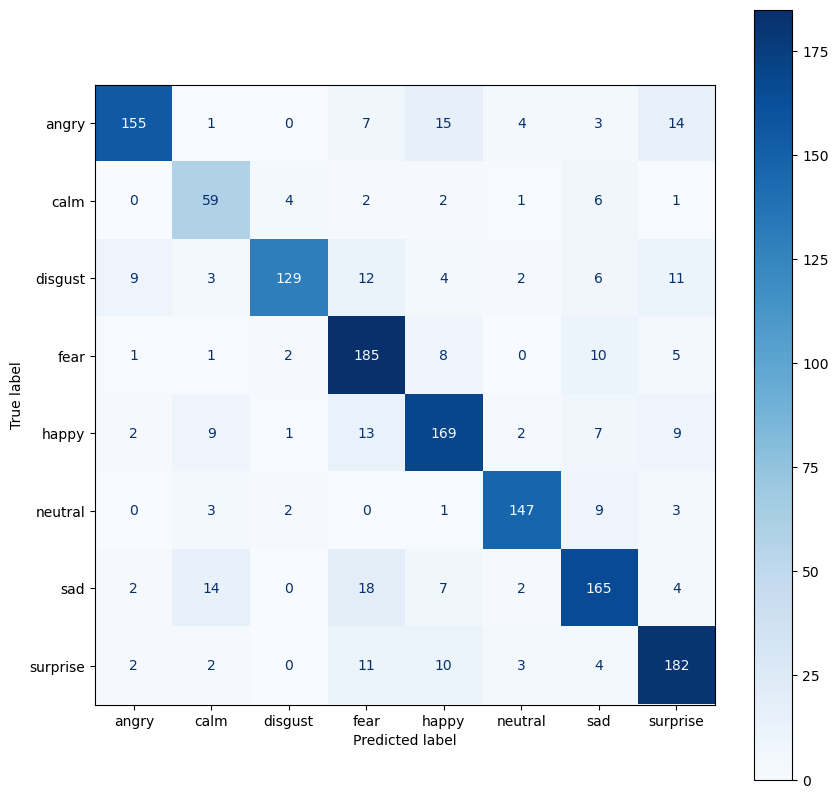

In [67]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes(111)
ConfusionMatrixDisplay.from_predictions(new_y_test, predictions, display_labels=encoder.classes_, ax=ax, cmap="Blues")
plt.show()